# **Diagonal preconditioning**

One of the simplest choices for the preconditioner $M$ is a diagonal matrix. This definitely meets the requirement of being fast to invert: the solution of $Mv =y$ is just $v_i = y_i/M_ii$ The only question is whether it can be chosen in such a way that $M^{-1}A$ is much more amenable to krylov iterations than $A$.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import random, eye
from scipy.sparse.linalg import spilu, LinearOperator,  aslinearoperator
def spd_from_gram(n, eps=1e-6, rng=None):
    rng = np.random.default_rng(rng)
    B = rng.normal(size=(n, n))
    A = B.T @ B
    A += eps * np.eye(n)       
    return B,A # Matriz no SPD, Matriz SPD
import numpy as np
from scipy.sparse import diags, kron, eye

def cholesky_in(A):
    n = A.shape[0]
    L = np.zeros_like(A)

    for i in range(n):
        for j in range(i+1):
      
            if j < i and A[i, j] == 0:
                L[i, j] = 0.0  
                continue
            s = 0.0
            for k in range(j):
                s += L[i, k] * L[j, k]
            if i == j:

                L[i, j] = np.sqrt((A[i, i] - s)) 
            else:
                L[i, j] = (A[i, j] - s) / L[j, j]

    return L


In [3]:
seed = 42

def get_diagonal_dominant_matrix(n, low=-10, high=10):
    """Generate a random n x n diagonally dominant matrix."""
    np.random.seed(seed)
    A = np.random.randint(low, high, size=(n, n)).astype(float)
    for i in range(n):
        A[i, i] = sum(np.abs(A[i])) + 10  # Ensure diagonal dominance
    return A

N = 500
A = get_diagonal_dominant_matrix(N)
x_true = np.random.randint(-10, 10, size=N).astype(float)
b = A @ x_true

# print("Matrix A:")
# print(A)
# print("x_true =", x_true)
# print("b =", b)


In [4]:
def gmres(A, b, m):
    """
    gmres(A, b, m)

    Do m iterations of GMRES for the linear system A*x=b. Return the final solution
    estimate x and a vector with the history of residual norms. (This function is for
    demo only, not practical use.)
    """
    n = len(b)
    Q = np.zeros([n, m + 1])
    Q[:, 0] = b / np.linalg.norm(b)
    H = np.zeros([m + 1, m])

    # Initial "solution" is zero.
    residual = np.hstack([np.linalg.norm(b), np.zeros(m)])

    for j in range(m):
        # Next step of Arnoldi iteration.
        v = A @ Q[:, j]
        for i in range(j + 1):
            H[i, j] = Q[:, i] @ v
            v -= H[i, j] * Q[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        Q[:, j + 1] = v / H[j + 1, j]

        # Solve the minimum residual problem.
        r = np.hstack([np.linalg.norm(b), np.zeros(j + 1)])
        z = np.linalg.lstsq(H[:j + 2, :j + 1], r)[0]
        x = Q[:, :j + 1] @ z
        residual[j + 1] = np.linalg.norm(A @ x - b)

    return x, residual

## Preconditioning Effectiveness

C:\Users\diego\AppData\Local\Temp\ipykernel_16768\2227864861.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z = np.linalg.lstsq(H[:j + 2, :j + 1], r)[0]


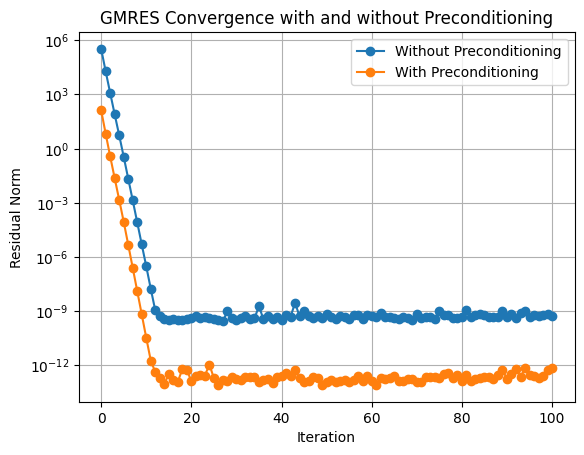

In [5]:
iters = 100
x = np.arange(iters + 1)
_, residuals_without = gmres(A, b, iters)

M_inv = np.diag(1/np.diag(A)) 
A_tilde = M_inv @ A
b_tilde = M_inv @ b
_, residuals_with = gmres(A_tilde, b_tilde, iters)

# plot 
plt.semilogy(x, residuals_without, 'o-', label='Without Preconditioning')
plt.semilogy(x, residuals_with, 'o-', label='With Preconditioning')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('GMRES Convergence with and without Preconditioning')
plt.legend()
plt.grid()
plt.show()





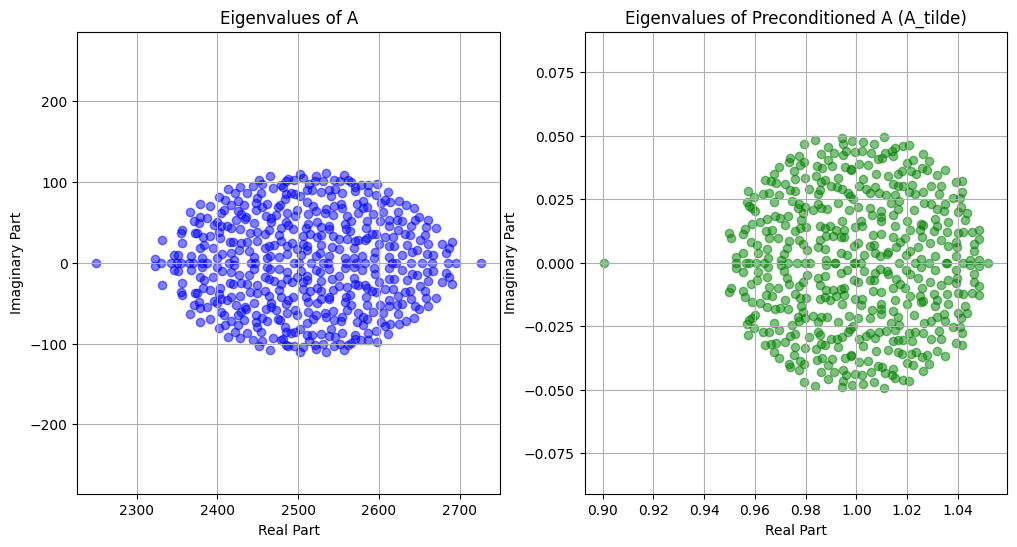

In [6]:
# Plot eigenvalues
eigenvalues_A = np.linalg.eigvals(A)
eigenvalues_A_tilde = np.linalg.eigvals(A_tilde)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(eigenvalues_A.real, eigenvalues_A.imag, color='blue', alpha=0.5)
plt.title('Eigenvalues of A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.scatter(eigenvalues_A_tilde.real, eigenvalues_A_tilde.imag, color='green', alpha=0.5)
plt.title('Eigenvalues of Preconditioned A (A_tilde)')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.show()

# LU Preconditioning

In [7]:
# reproducibilidad
seed = 42+1
density = 0.3
N = 2025
# Matriz dispersa aleatoria
A = random(N, N, density=density, format='csr', random_state=seed)  + 1e-2 * eye(N, format='csr')
b = np.random.random(N)
print("Matriz sparse (CSR):")
print(A)

# Factorización ILU incompleta
ilu = spilu(A)
# Construir el precondicionador como LinearOperator
M_inv = LinearOperator(A.shape, ilu.solve) #wtf
A = aslinearoperator(A)
b_tilde = M_inv @ b
A_tilde = M_inv @ A

print("\nVector original b:", b)
print("Vector transformado M^{-1} b:", b_tilde)
print("\nMatriz original A:")
print(A)
print("Matriz transformada M^{-1} A:")
print(A_tilde)


Matriz sparse (CSR):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1231601 stored elements and shape (2025, 2025)>
  Coords	Values
  (0, 0)	0.01
  (0, 3)	0.41531672968663313
  (0, 4)	0.9174528282491128
  (0, 10)	0.4844110514280999
  (0, 13)	0.2423425761412491
  (0, 17)	0.5249158845979316
  (0, 19)	0.6205240342247392
  (0, 20)	0.4442985679182343
  (0, 21)	0.6059515017868163
  (0, 27)	0.8258433710812245
  (0, 29)	0.7176312750681207
  (0, 30)	0.5936637022811818
  (0, 33)	0.3106802833656813
  (0, 36)	0.737857213970317
  (0, 38)	0.44598375225573517
  (0, 43)	0.6089888009125006
  (0, 52)	0.1222253881073575
  (0, 53)	0.4962507775611188
  (0, 57)	0.25805849312769413
  (0, 62)	0.7555406542130125
  (0, 71)	0.1778518614188418
  (0, 72)	0.7564176785749948
  (0, 78)	0.06944458039769075
  (0, 79)	0.2675391886961135
  (0, 82)	0.927209045843884
  :	:
  (2024, 1947)	0.6329799600493927
  (2024, 1948)	0.4107765691727461
  (2024, 1949)	0.4302500288924016
  (2024, 1953)	0.27127453527696876


C:\Users\diego\AppData\Local\Temp\ipykernel_16768\1854863581.py:12: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(A)



Vector original b: [0.32684189 0.17623153 0.26982856 ... 0.33436385 0.26955061 0.55663057]
Vector transformado M^{-1} b: [ 0.24584814  0.22562677  0.04420391 ... -0.03041519 -0.11115312
 -0.32713328]

Matriz original A:
<2025x2025 MatrixLinearOperator with dtype=float64>
Matriz transformada M^{-1} A:
<2025x2025 _ProductLinearOperator with dtype=float64>


In [8]:
from scipy.sparse.linalg import gmres, cg

b = np.random.rand(N)
hist = lambda rvec: resid.append(np.linalg.norm(rvec))
resid = []


x, flag = gmres(A, b, maxiter=50, rtol=1e-10, restart=50, callback=hist)
resid_plain = resid.copy()

In [9]:
from scipy.sparse.linalg import LinearOperator
prec = LinearOperator((N, N), matvec=ilu.solve)
resid = []

x, flag = gmres(A, b, M=prec, maxiter=50, rtol=1e-10, restart=50, callback=hist)

resid_prec = resid

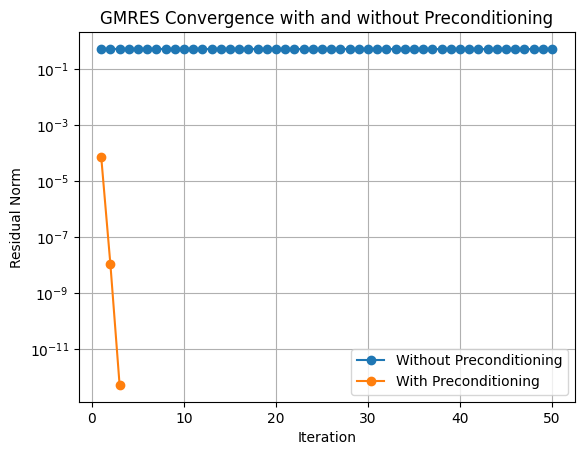

In [10]:
iters_without = np.arange(1, len(resid_plain)+1)
iters_with = np.arange(1, len(resid_prec)+1)

plt.semilogy(iters_without, resid_plain, 'o-', label='Without Preconditioning')
plt.semilogy(iters_with, resid_prec, 'o-', label='With Preconditioning')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('GMRES Convergence with and without Preconditioning')
plt.legend()
plt.grid()
plt.show()

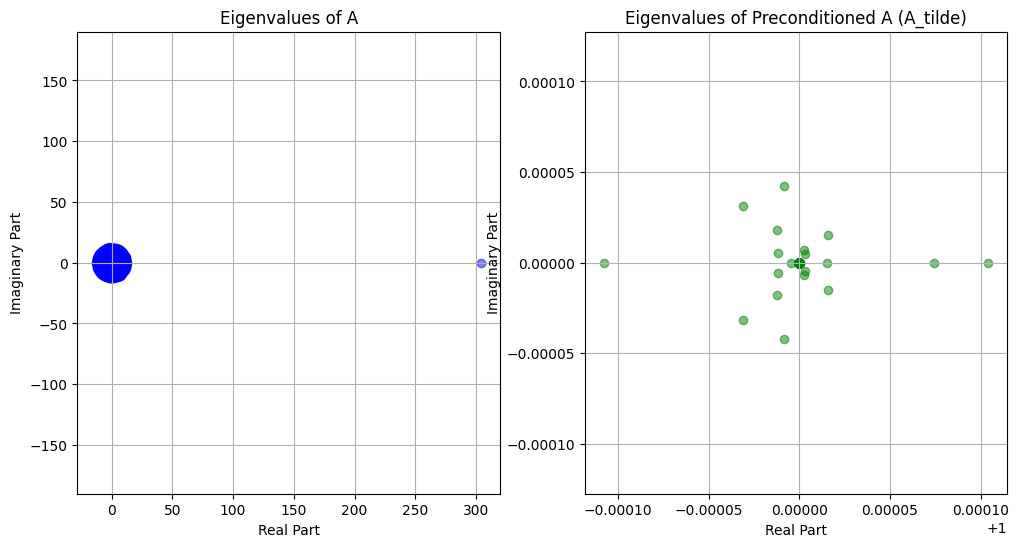

In [11]:
# Plot eigenvalues
eigenvalues_A = np.linalg.eigvals(A  @ np.eye(2025) )
eigenvalues_A_tilde = np.linalg.eigvals(A_tilde @ np.eye(2025))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(eigenvalues_A.real, eigenvalues_A.imag, color='blue', alpha=0.5)
plt.title('Eigenvalues of A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.scatter(eigenvalues_A_tilde.real, eigenvalues_A_tilde.imag, color='green', alpha=0.5)
plt.title('Eigenvalues of Preconditioned A (A_tilde)')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.show()

In [12]:
n = 2025
A = 2.8 * sp.eye(n) + sp.rand(n, n, 0.002)
from scipy.sparse.linalg import gmres

b = np.random.rand(n)
hist = lambda rvec: resid.append(np.linalg.norm(rvec))
resid = [1.]


x, flag = gmres(A, b, maxiter=50, rtol=1e-10, restart=50, callback=hist)

resid_plain = resid.copy()
from scipy.sparse.linalg import spilu
iLU = spilu(A, drop_tol=0.2)
print(f"Factors have {iLU.nnz} nonzeros, while A has {A.nnz}")

Factors have 13965 nonzeros, while A has 10222


C:\Users\diego\AppData\Local\Temp\ipykernel_16768\3963227019.py:14: SparseEfficiencyWarning: spilu converted its input to CSC format
  iLU = spilu(A, drop_tol=0.2)


In [13]:
from scipy.sparse.linalg import LinearOperator
prec = LinearOperator((n, n), matvec=lambda y: iLU.solve(y))

resid = []
x, flag = gmres(A, b, M=prec, maxiter=50, rtol=1e-10, restart=50, callback=hist)

resid_prec = resid

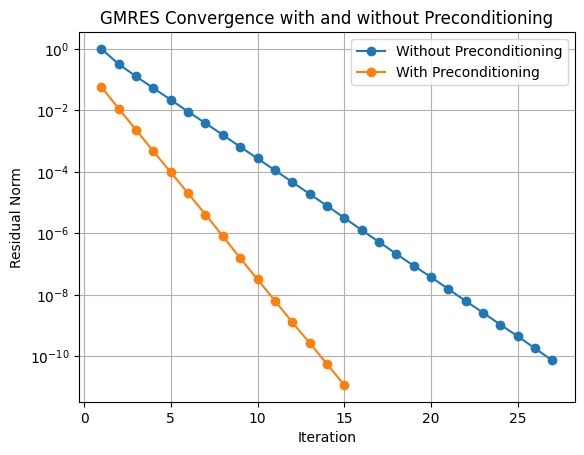

In [14]:
iters_without = np.arange(1, len(resid_plain)+1)
iters_with = np.arange(1, len(resid_prec)+1)

plt.semilogy(iters_without, resid_plain, 'o-', label='Without Preconditioning')
plt.semilogy(iters_with, resid_prec, 'o-', label='With Preconditioning')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('GMRES Convergence with and without Preconditioning')
plt.legend()
plt.grid()
plt.show()

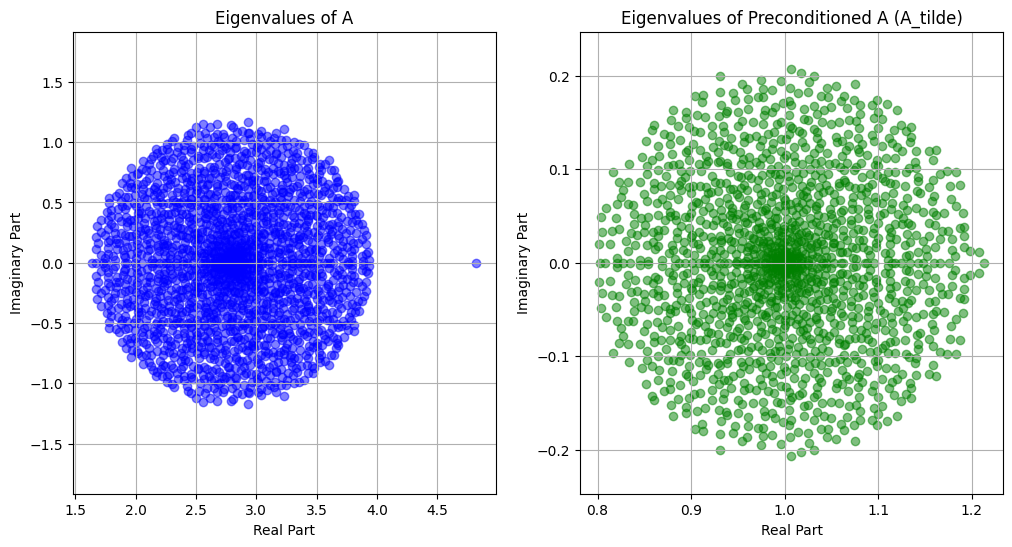

In [15]:
# Plot eigenvalues
eigenvalues_A = np.linalg.eigvals(A  @ np.eye(n) )
A = aslinearoperator(A)
eigenvalues_A_tilde = np.linalg.eigvals( prec @ A  @ np.eye(n) )
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(eigenvalues_A.real, eigenvalues_A.imag, color='blue', alpha=0.5)
plt.title('Eigenvalues of A')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.scatter(eigenvalues_A_tilde.real, eigenvalues_A_tilde.imag, color='green', alpha=0.5)
plt.title('Eigenvalues of Preconditioned A (A_tilde)')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid()
plt.axis('equal')
plt.show()

# Conjugate gradient

In [45]:
from scipy.sparse import issparse, diags
from scipy.sparse.linalg import LinearOperator, cg
def jacobi_preconditioner(A, eps=0.0):
    """Devuelve un LinearOperator que aplica D^{-1} (Jacobi).
       eps > 0 añade un pequeño desplazamiento a la diagonal si hay ceros/pequeños."""
    # extraer la diagonal
    if issparse(A):
        D = A.diagonal().astype(float)
    else:
        D = np.diag(A).astype(float)

    if eps > 0:
        D = D + eps
    # evita divisiones por 0
    D[D == 0.0] = 1.0

    invD = 1.0 / D
    n = A.shape[0]
    return LinearOperator((n, n), matvec=lambda v: invD * v)

In [139]:
from scipy.sparse import diags, kron, eye
N  = 100
_, A = spd_from_gram(N)
# A = laplaciano_2d(N)
# A

In [140]:


b = np.random.random(N)
residuals_sin = []
def historial_sin(xk):
    rk = b - A @ xk          # residual no precondicionado
    residuals_sin.append(np.linalg.norm(rk))

x, info = cg(A, b, callback=historial_sin)
info

0

In [154]:
residuals_con = []
Mj = jacobi_preconditioner(A, eps=1e-12)
def historial_con(xk):
    rk = b - A @ xk          # residual no precondicionado
    residuals_con.append(np.linalg.norm(rk))
x, info = cg(A, b, callback=historial_con, M=Mj)    
Mj @ A

ValueError: cannot reshape array of size 10000 into shape (100,1)

In [142]:
iLU = spilu(A, drop_tol=0.2)
precilu = LinearOperator((N, N), matvec=lambda y: iLU.solve(y))
residuals_con_=[]
def historial_con_(xk):
    rk = b - A @ xk          
    residuals_con_.append(np.linalg.norm(rk))
x, flag = cg(A, b, callback=historial_con_, M=precilu, maxiter=N*2)
np.linalg.norm(A@x-b)

C:\Users\diego\AppData\Local\Temp\ipykernel_16768\113443204.py:1: SparseEfficiencyWarning: spilu converted its input to CSC format
  iLU = spilu(A, drop_tol=0.2)


6.739439731086537

In [143]:
from scipy.linalg import solve_triangular
prec_chol = ichol(A.copy())
prec_chol

array([[ 9.50769411e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.32347978e+00,  1.06176915e+01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.05750464e+00, -3.19338739e-01,  1.02785582e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.24139150e-01, -1.18296840e+00, -1.36100386e-01, ...,
         1.93273853e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.97425199e-01,  4.83616116e-03,  3.77670966e-01, ...,
        -7.43038035e-01,  6.96986111e-01,  0.00000000e+00],
       [-6.62832693e-01,  5.06920088e-01, -4.05247994e-01, ...,
        -1.18076428e+00,  4.52786306e-01,  1.50664106e+00]])

In [144]:
def apply_prec(v: np.ndarray) -> np.ndarray:
    y = solve_triangular(prec_chol, v, lower=True, check_finite=False)
    z = solve_triangular(prec_chol.T, y, lower=False, check_finite=False)
    return z

Michol = LinearOperator(A.shape, matvec=apply_prec, dtype=A.dtype)
residuals_con_CH=[]
def historial_con_(xk):
    rk = b - A @ xk          # residual no precondicionado
    residuals_con_CH.append(np.linalg.norm(rk))
x, flag = cg(A, b, callback=historial_con_, M=Michol, )

In [145]:
np.diag(M@A)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [146]:
np.linalg.norm(M@A - np.diag(np.diag(M@A)))

7.2311089436397995e-12

In [147]:
np.linalg.norm(A@x-b)

2.9480082888806387e-12

In [148]:
np.linalg.cond(A)

74995.9574777145

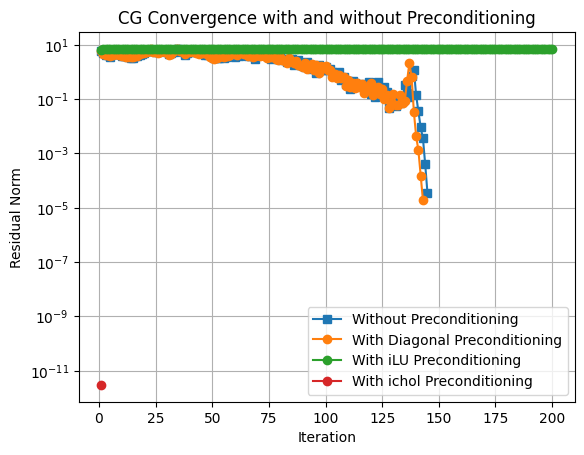

In [ ]:
iters_without = np.arange(1, len(residuals_sin )+1)
iters_with = np.arange(1, len(residuals_con )+1)
iters_with_ = np.arange(1, len(residuals_con_ )+1)
iters_with_ch = np.arange(1, len(residuals_con_CH )+1)


plt.semilogy(iters_without, residuals_sin , 's-', label='Without Preconditioning')
plt.semilogy(iters_with, residuals_con , 'o-', label='With Diagonal Preconditioning')
plt.semilogy(iters_with_, residuals_con_ , 'o-', label='With iLU Preconditioning ')
plt.semilogy(iters_with_ch, residuals_con_CH , 'o-', label='With ichol Preconditioning ')


plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('CG Convergence with and without Preconditioning')
plt.legend()
plt.grid()
plt.show()

In [168]:
def precond_matrix(A_mat, M):
    A_dense = A_mat.toarray() if hasattr(A_mat, "toarray") else np.array(A_mat)
    n = A_dense.shape[0]
    cols = [M.matvec(A_dense[:, j]) for j in range(n)]
    return np.column_stack(cols)



A_prec_ichol = precond_matrix(A, Michol)
A_prec_jac = precond_matrix(A, Mj)
A_ilu     = precond_matrix(A, precilu)  
A_ichol   = A_prec_ichol
A_prec_jac

array([[ 1.        , -0.13920092, -0.1112262 , ..., -0.08668129,
        -0.07335377, -0.0697154 ],
       [-0.10990981,  1.        , -0.0173911 , ..., -0.10018312,
         0.00851081,  0.05467493],
       [-0.09408178, -0.01863078,  1.        , ..., -0.0014    ,
         0.04321082, -0.03393214],
       ...,
       [-0.07204557, -0.10545864, -0.00137567, ...,  1.        ,
         0.23033937,  0.17524844],
       [-0.05707517,  0.0083869 ,  0.03974832, ...,  0.21563092,
         1.        ,  0.12014486],
       [-0.06290762,  0.06248394, -0.03619823, ...,  0.19025967,
         0.13933329,  1.        ]])

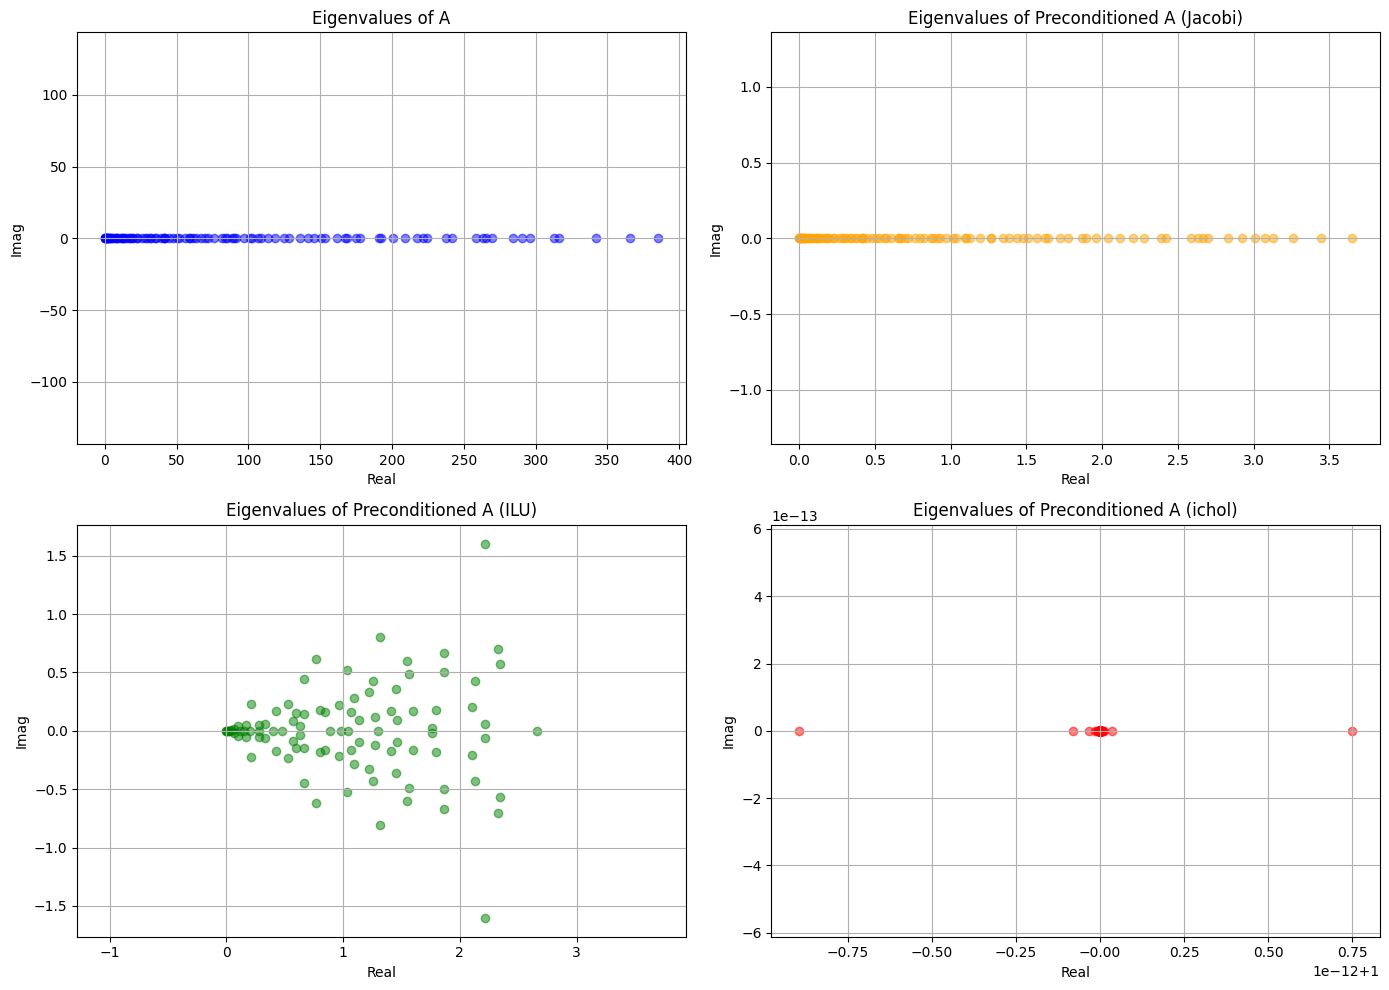

In [169]:


eigs_jacobi = np.linalg.eigvals(A_prec_jac)
eigs_ilu    = np.linalg.eigvals(A_ilu)
eigs_ichol  = np.linalg.eigvals(A_ichol)
eigs_A      = np.linalg.eigvals(A.toarray() if hasattr(A, "toarray") else A)
# Graficar
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.scatter(eigs_A.real, eigs_A.imag, c='b', alpha=0.5)
plt.title("Eigenvalues of A")
plt.xlabel("Real"); plt.ylabel("Imag"); plt.axis("equal"); plt.grid()

plt.subplot(2,2,2)
plt.scatter(eigs_jacobi.real, eigs_jacobi.imag, c='orange', alpha=0.5)
plt.title("Eigenvalues of Preconditioned A (Jacobi)")
plt.xlabel("Real"); plt.ylabel("Imag"); plt.axis("equal"); plt.grid()

plt.subplot(2,2,3)
plt.scatter(eigs_ilu.real, eigs_ilu.imag, c='g', alpha=0.5)
plt.title("Eigenvalues of Preconditioned A (ILU)")
plt.xlabel("Real"); plt.ylabel("Imag"); plt.axis("equal"); plt.grid()

plt.subplot(2,2,4)
plt.scatter(eigs_ichol.real, eigs_ichol.imag, c='r', alpha=0.5)
plt.title("Eigenvalues of Preconditioned A (ichol)")
plt.xlabel("Real"); plt.ylabel("Imag"); plt.axis("equal"); plt.grid()

plt.tight_layout()
plt.show()

In [90]:
from scipy.sparse.linalg import cg, LinearOperator, spsolve_triangular
from scipy.linalg import solve_triangular
def make_ic_precond(ichol):
    n = ichol.shape[0]
    def apply_Minv(x):
        z = spsolve_triangular(ichol, x, lower=True)
        y = spsolve_triangular(ichol.T, z, lower=False)
        return y
    return LinearOperator((n, n), matvec=apply_Minv, rmatvec=apply_Minv)
def construir_spd_densa(n,densidad):
    A = sp.random_array((n,n),density=densidad, format='csr', dtype=float) 
    tau = 1e-2
    return (A.T @ A) + tau * sp.eye(n, format='csr')

n = 20
A = construir_spd_densa(n,0.2).toarray()
# print(A)
icA = cholesky_in(A)
M = make_ic_precond(icA)
b = np.random.rand(n)
hist_con = []
callback_con = lambda x: hist_con.append(np.linalg.norm(b - A@x))
x, info = cg(A, b,M=M, maxiter=1000, callback=callback_con)


C:\Users\diego\AppData\Local\Temp\ipykernel_19976\3517584694.py:6: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  z = spsolve_triangular(ichol, x, lower=True)
C:\Users\diego\AppData\Local\Temp\ipykernel_19976\3517584694.py:7: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  y = spsolve_triangular(ichol.T, z, lower=False)


In [91]:
hist_sin = []
callback_sin = lambda x: hist_sin.append(np.linalg.norm(b - A@x))
x, info = cg(A, b,maxiter=1000, callback=callback_sin)

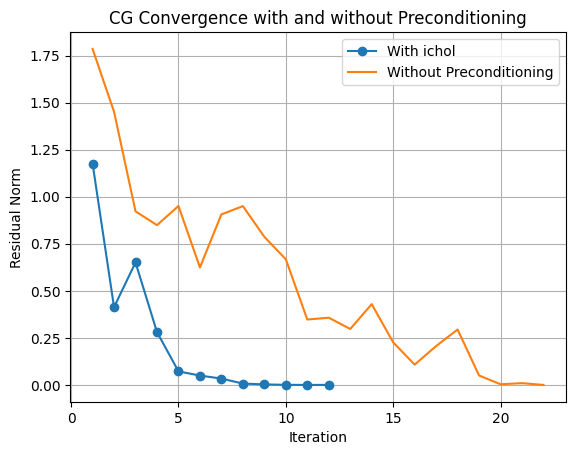

In [92]:
iters_without = np.arange(1, len(hist_sin )+1)
iters_with_ch = np.arange(1, len(hist_con )+1)


plt.plot(iters_with_ch, hist_con , 'o-', label='With ichol')
plt.plot(iters_without, hist_sin , '-', label='Without Preconditioning')
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('CG Convergence with and without Preconditioning')
plt.legend()
plt.grid()
plt.show()

In [93]:
np.linalg.norm(M@A - np.diag(np.diag(M@A)))

C:\Users\diego\AppData\Local\Temp\ipykernel_19976\3517584694.py:6: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  z = spsolve_triangular(ichol, x, lower=True)
C:\Users\diego\AppData\Local\Temp\ipykernel_19976\3517584694.py:7: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  y = spsolve_triangular(ichol.T, z, lower=False)


5.013194131629695

In [50]:
%timeit cg(A, b,M=M, maxiter=1000, callback=callback_con)

1.09 ms ± 19.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [51]:
%timeit cg(A, b, maxiter=1000, callback=callback_con)

771 μs ± 27.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


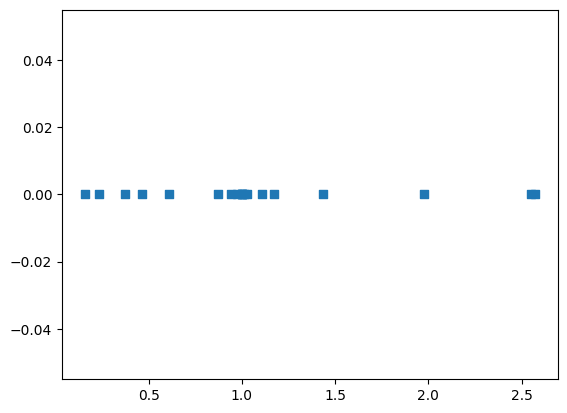

In [45]:
eigs_ichol  = np.linalg.eigvals(M@A)
plt.scatter(eigs_ichol.real,eigs_ichol.imag, marker='s')


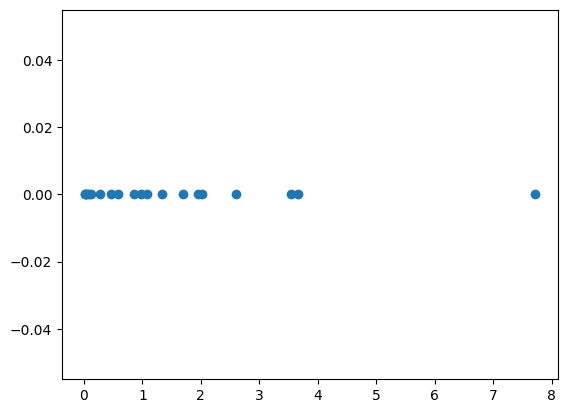

In [44]:
eigs_a  = np.linalg.eigvals(A)
plt.scatter(eigs_a.real,eigs_a.imag, marker='o')